In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 205ms/step - loss: 0.2543 - root_mean_squared_error: 0.5043 - val_loss: 0.2031 - val_root_mean_squared_error: 0.4507
Epoch 2/50
53/53 [==============================] - 10s 194ms/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3080
Epoch 3/50
53/53 [==============================] - 10s 189ms/step - loss: 0.1002 - root_mean_squared_error: 0.3166 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2966
Epoch 4/50
53/53 [==============================] - 11s 205ms/step - loss: 0.0924 - root_mean_squared_error: 0.3039 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2805
Epoch 5/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0852 - root_mean_squared_error: 0.2919 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 6/50
53/53 [==============================] - 10s 185ms/step - loss: 0.0705 - root_mean_squared_error: 0.2655 - val_loss: 0.0554 

53/53 [==============================] - 10s 195ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 33/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0067 - root_mean_squared_error: 0.0818 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711
Epoch 35/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 36/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 37/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0084 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.299855860074361 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

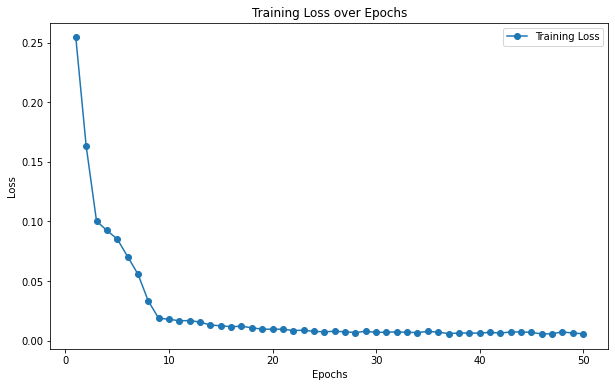

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

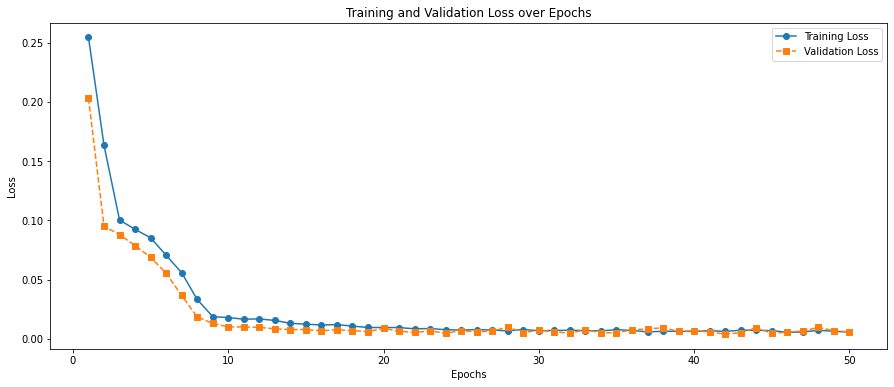

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.055090435448204085
MAE : 0.04338618516886897


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.963196e+06,2526913.818
1,1.482711e+06,1128752.378
2,6.186462e+05,522831.371
3,2.958381e+05,346601.304
4,2.235723e+05,444914.605
5,4.407534e+05,827036.916
6,1.153255e+06,1142021.216
7,1.899102e+06,1885693.654
8,2.374679e+06,2542569.663
9,2.778392e+06,3107373.845


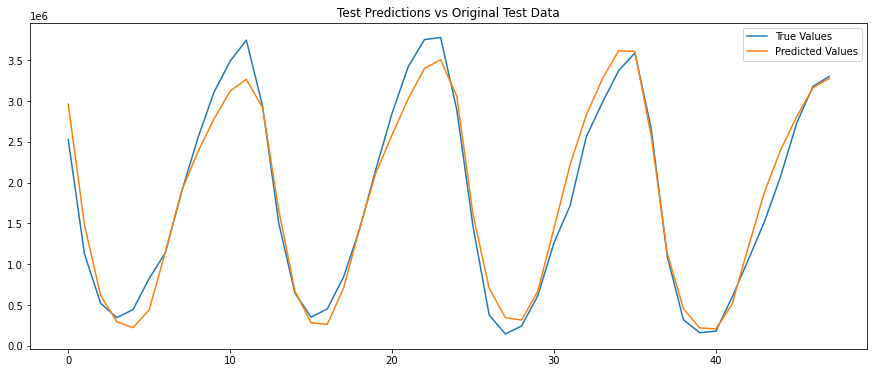

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 17ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

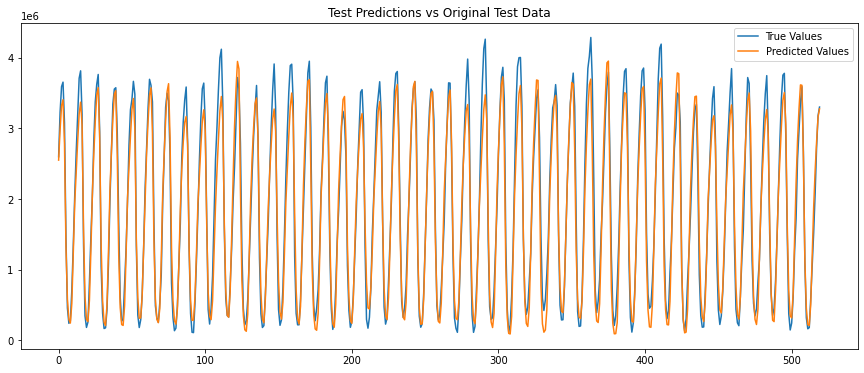

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()